In [5]:
# Boxing Match Predictor

# This is my main development notebook where I built and tested my machine learning model to predict the outcome of boxing matches. My goal was to go through the entire data science process from start to finish.

# My process follows these key steps:
# 1.  Data Loading and Cleaning: Getting the raw data ready for analysis.
# 2.  Feature Engineering: Creating new and insightful features from the base stats.
# 3.  Model Training & Tuning: Building and finding the best settings for my models.
# 4.  Ensembling & Calibration: Combining my models to make them more powerful and their predictions more reliable.
# 5.  Evaluation: Checking how well the final model performs on data it's never seen before.
# 6.  Explainability: Using SHAP to understand why the model makes its predictions.
#
# Note: After developing the logic here, I refactored all these functions into a clean `src` library to build my final Streamlit web app.

# First, I'll import all the libraries I need for the project. I'm using standard libraries like pandas and scikit-learn, along with XGBoost for the model and SHAP for explainability.

# Core libraries
import pandas as pd
import numpy as np
import json, logging, warnings, re
warnings.filterwarnings("ignore")

# Scikit-learn for modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    balanced_accuracy_score, f1_score, roc_curve, auc
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE

# For plotting charts
import matplotlib.pyplot as plt

# For saving and loading my model files
import joblib, os

# Other libraries
import xgboost as xgb
from difflib import get_close_matches

# I made SHAP an optional import. This means my code can still run
# even if the SHAP library isn't installed.
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

# Setting up simple logging to see progress messages.
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [6]:
# Data Loading and Cleaning
# Here, I load my `boxing_data.csv` file. The main cleaning steps I took were:
# - Making sure the `Result` column is a simple binary value (1 for Fighter A win, 0 for anything else).
# - Checking that all the stat columns are correctly formatted as numbers.

def load_and_clean_data(csv_path="boxing_data.csv"):
    df = pd.read_csv(csv_path)

    # I'm simplifying the target variable: 1 is a win for A, 0 is a loss or draw.
    df["Result"] = df["Result"].apply(lambda x: 1 if x == 1 else 0)

    numeric_cols = [
        "ReachA","ReachB","HeightA","HeightB","WeightA","WeightB",
        "AgeA","AgeB","WinsA","WinsB","KOPercA","KOPercB",
        "RecentWinPercA","RecentWinPercB","DefensePercA","DefensePercB",
        "PunchAccuracyA","PunchAccuracyB","StrengthOfScheduleA","StrengthOfScheduleB",
        "TimeSinceLastFightA","TimeSinceLastFightB","Result"
    ]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=["Result"])

    logging.info(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    print("Proportion of wins (1) vs losses/draws (0):")
    print(df["Result"].value_counts(normalize=True).rename("proportion"))
    return df

# I need to use the correct path relative to where my notebook is.
df = load_and_clean_data("data/boxing_data.csv")
df.head()

INFO: Dataset loaded with 304 rows and 47 columns


Proportion of wins (1) vs losses/draws (0):
Result
1    0.634868
0    0.365132
Name: proportion, dtype: float64


,FighterA,FighterB,ReachA,ReachB,HeightA,HeightB,WeightA,WeightB,AgeA,AgeB,...,AvgOpponentWinPercB,StrengthOfScheduleA,StrengthOfScheduleB,StanceA,StanceB,WeightClassA,WeightClassB,TitleFight,LocationAdvantage,Result
0,Dmitry Bivol,Canelo Alvarez,183,179,183,171,174.0,174.0,31,31,...,0.78,8.0,10.0,Orthodox,Orthodox,LightHeavyweight,LightHeavyweight,1,0.0,1
1,Muhammad Ali,Joe Frazier,198,187,191,182,215.0,205.5,29,27,...,0.74,10.0,9.0,Orthodox,Orthodox,Heavyweight,Heavyweight,1,0.0,0
2,Thomas Hearns,Marvin Hagler,198,191,185,178,159.5,159.0,26,30,...,0.76,9.0,10.0,Orthodox,Southpaw,Middleweight,Middleweight,1,0.0,0
3,Floyd Mayweather,Manny Pacquiao,183,170,173,165,154.0,154.0,38,36,...,0.76,10.0,10.0,Orthodox,Southpaw,Welterweight,Welterweight,1,0.0,1
4,Lennox Lewis,Vitali Klitschko,213,201,196,201,244.0,248.5,37,31,...,0.72,10.0,9.0,Orthodox,Orthodox,Heavyweight,Heavyweight,1,0.0,1


In [7]:
# Feature Engineering
# This was one of the most important parts of the project for me. I realised that the model would probably learn more from the difference between two fighters' stats, rather than their raw numbers. For example, a fighter's height isn't as important as their height advantage over their opponent.
# So, I created a set of 'Diff' features. I also made some more complex interaction features to capture ideas like how a fighter's knockout power holds up against tougher opponents.

def engineer_features(df):
    # These are the direct, one-to-one comparisons of the fighters.
    df["ReachDiff"]      = df["ReachA"]  - df["ReachB"]
    df["AgeDiff"]        = df["AgeA"]    - df["AgeB"]
    df["HeightDiff"]     = df["HeightA"] - df["HeightB"]
    df["WeightDiff"]     = df["WeightA"] - df["WeightB"]
    df["KODiff"]         = df["KOPercA"] - df["KOPercB"]
    df["WinDiff"]        = df["WinsA"]   - df["WinsB"]
    df["RecentWinPercDiff"] = df["RecentWinPercA"] - df["RecentWinPercB"]
    df["DefenseDiff"]    = df["DefensePercA"] - df["DefensePercB"]
    df["PunchAccDiff"]   = df["PunchAccuracyA"] - df["PunchAccuracyB"]
    df["SoSDiff"]        = df["StrengthOfScheduleA"] - df["StrengthOfScheduleB"]
    df["TimeSinceDiff"]  = df["TimeSinceLastFightA"] - df["TimeSinceLastFightB"]

    # I came up with these interaction features to add more context.
    # For example, 'PowerVsSchedule' looks at knockout power relative to opponent quality.
    df["PowerVsSchedule"]   = df["KODiff"] * df["SoSDiff"]
    df["WinsVsSchedule"]    = df["WinDiff"] * df["SoSDiff"]
    df["RecentFormWeighted"] = df["RecentWinPercDiff"] * (1 + 0.5 * (df["SoSDiff"] / (1 + df["SoSDiff"].abs())))

    feature_cols = [
        "ReachDiff","AgeDiff","HeightDiff","WeightDiff",
        "KODiff","WinDiff","RecentWinPercDiff","DefenseDiff","PunchAccDiff",
        "SoSDiff","TimeSinceDiff",
        "PowerVsSchedule","WinsVsSchedule","RecentFormWeighted"
    ]
    return df, feature_cols

df, feature_cols = engineer_features(df)
print(f"I created {len(feature_cols)} features for the model.")
print("The features are:", feature_cols)

I created 14 features for the model.
The features are: ['ReachDiff', 'AgeDiff', 'HeightDiff', 'WeightDiff', 'KODiff', 'WinDiff', 'RecentWinPercDiff', 'DefenseDiff', 'PunchAccDiff', 'SoSDiff', 'TimeSinceDiff', 'PowerVsSchedule', 'WinsVsSchedule', 'RecentFormWeighted']


In [8]:
# Data Preparation for Modelling
# In this section, I prepare the data for the training process.
# - I fill in any missing values using the mean of each column.
# - I split the data into a training set and a test set (80/20 split).
# - I use SMOTE on the training data to handle the fact that my dataset has more losses than wins. This helps prevent the model from being biased.
# I separate my new features (X) from the target (y).

X = df[feature_cols].copy()
y = df["Result"].astype(int).copy()

# I use a simple imputer to fill any missing values with the column average.
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# Here I split the data, keeping 20% aside to test the final model on.
# 'stratify=y' makes sure the train and test sets have a similar balance of wins/losses.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# I apply SMOTE to the training set to create more examples of the minority class.
# Making sure to only do this to the training data.
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

logging.info(f"Original training data class balance: {y_train.value_counts().to_dict()}")
logging.info(f"Training data class balance after SMOTE: {y_train_res.value_counts().to_dict()}")

# This is the cross-validation strategy I'll use during tuning.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

INFO: Original training data class balance: {1: 154, 0: 89}
INFO: Training data class balance after SMOTE: {0: 154, 1: 154}


In [9]:
# Model Training and Tuning
# I decided to build an ensemble model, which combines the predictions of several different models to get a better result. My ensemble consists of a Random Forest, an XGBoost model, and a simple Logistic Regression.
# First, I use RandomizedSearchCV to automatically find the best hyperparameter settings for the Random Forest and XGBoost models.

# Random Forest Tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_dist = {
    "n_estimators":  [200, 300, 500, 700, 900],
    "max_depth":     [6, 10, 14, 18, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":  ["sqrt", "log2", None]
}
rf_search = RandomizedSearchCV(
    rf, rf_dist, n_iter=30, scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42, verbose=0
)
rf_search.fit(X_train_res, y_train_res)
rf_best = rf_search.best_estimator_
logging.info(f"RF best params: {rf_search.best_params_}")

# XGBoost Tuning 
xgb_base = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)
xgb_dist = {
    "n_estimators": [300, 500, 700, 900],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7]
}
xgb_search = RandomizedSearchCV(
    xgb_base, xgb_dist, n_iter=30, scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42, verbose=0
)
xgb_search.fit(X_train_res, y_train_res)
xgb_best = xgb_search.best_estimator_
logging.info(f"XGB best params: {xgb_search.best_params_}")

INFO: RF best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 18}
INFO: XGB best params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.6}



=== FINAL ENSEMBLE PERFORMANCE (ON TEST SET) ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.86      0.95      0.90        39

    accuracy                           0.87        61
   macro avg       0.87      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[16  6]
 [ 2 37]]
ROC AUC Score: 0.8554778554778555


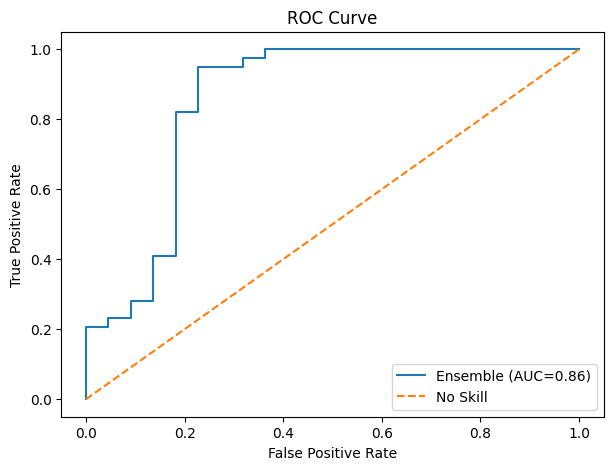

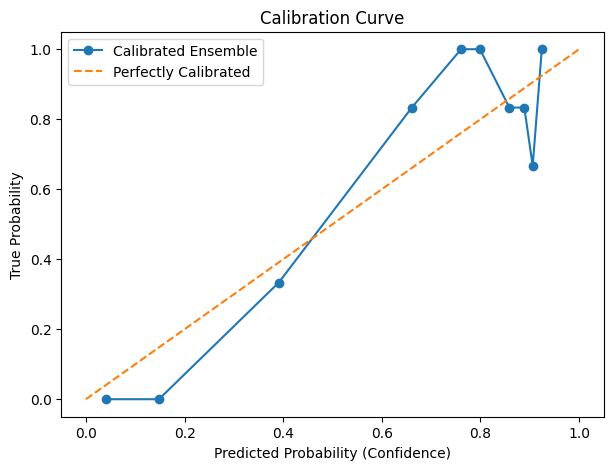

In [10]:
# Final Model Assembly and Evaluation
# Now that I have my tuned models, I'll combine them in a VotingClassifier. I chose soft voting because averaging the prediction probabilities is usually better than just taking a majority vote.
# I also calibrate the final model. This is an important step that makes the confidence scores (the probabilities) more reliable.
# Finally, I evaluate the model on the test set I held back at the start.

# Building the Ensemble
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
ensemble = VotingClassifier(
    estimators=[("rf", rf_best), ("xgb", xgb_best), ("lr", logreg)],
    voting="soft",
    n_jobs=-1
)
ensemble.fit(X_train_res, y_train_res)

# Calibrating the Model
# This makes the outputted probabilities more accurate.
final_model_calibrated = CalibratedClassifierCV(ensemble, cv=3, method="sigmoid")
final_model_calibrated.fit(X_train_res, y_train_res)

# Evaluating on the Test Set
y_pred = final_model_calibrated.predict(X_test)
y_proba = final_model_calibrated.predict_proba(X_test)[:, 1]

print("\n=== FINAL ENSEMBLE PERFORMANCE (ON TEST SET) ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plotting Evaluation Curves
# I'm plotting these to get a more visual understanding of my model's performance.

# The ROC Curve shows how well the model can distinguish between wins and losses.
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Ensemble (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1],[0,1],"--", label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# The Calibration Curve shows how reliable the model's confidence scores are.
# A good model should be close to the dashed diagonal line.
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='quantile')
plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label="Calibrated Ensemble")
plt.plot([0,1],[0,1],"--", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability (Confidence)")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [11]:
# Saving the Model
# After all that I save the final trained model and the imputer to a file. This means I can load them later in my web app without having to retrain everything from scratch.

joblib.dump(final_model_calibrated, "fight_predictor_ensemble.pkl")
joblib.dump(imputer, "imputer.pkl")
logging.info("Saved final model and imputer to disk.")

INFO: Saved final model and imputer to disk.


In [12]:
# Building the Prediction and Explanation Functions
# Now I'll create the functions that will power my final application. This section proves the saved model works as expected by making a test prediction.
# First, I need to build a dictionary of all the fighter stats from my dataframe to look them up easily.
fighters_stats = {}
for _, row in df.iterrows():
    fighters_stats[row["FighterA"]] = {
        "Reach": row["ReachA"], "Age": row["AgeA"], "Height": row["HeightA"],
        "Weight": row["WeightA"], "KO%": row["KOPercA"], "Wins": row["WinsA"],
        "RecentWin%": row["RecentWinPercA"], "Defense%": row["DefensePercA"],
        "PunchAcc": row["PunchAccuracyA"], "SoS": row["StrengthOfScheduleA"],
        "TimeSince": row["TimeSinceLastFightA"]
    }
    fighters_stats[row["FighterB"]] = {
        "Reach": row["ReachB"], "Age": row["AgeB"], "Height": row["HeightB"],
        "Weight": row["WeightB"], "KO%": row["KOPercB"], "Wins": row["WinsB"],
        "RecentWin%": row["RecentWinPercB"], "Defense%": row["DefensePercB"],
        "PunchAcc": row["PunchAccuracyB"], "SoS": row["StrengthOfScheduleB"],
        "TimeSince": row["TimeSinceLastFightB"]
    }
all_fighters = sorted(set(fighters_stats.keys()))

# This is a helper function to create the feature row for a single matchup.
def _build_feature_row(statsA, statsB):
    feats = {
        "ReachDiff": statsA["Reach"] - statsB["Reach"],
        "AgeDiff": statsA["Age"] - statsB["Age"],
        "HeightDiff": statsA["Height"] - statsB["Height"],
        "WeightDiff": statsA["Weight"] - statsB["Weight"],
        "KODiff": statsA["KO%"] - statsB["KO%"],
        "WinDiff": statsA["Wins"] - statsB["Wins"],
        "RecentWinPercDiff": statsA["RecentWin%"] - statsB["RecentWin%"],
        "DefenseDiff": statsA["Defense%"] - statsB["Defense%"],
        "PunchAccDiff": statsA["PunchAcc"] - statsB["PunchAcc"],
        "SoSDiff": statsA["SoS"] - statsB["SoS"],
        "TimeSinceDiff": statsA["TimeSince"] - statsB["TimeSince"]
    }
    feats["PowerVsSchedule"] = feats["KODiff"] * feats["SoSDiff"]
    feats["WinsVsSchedule"]  = feats["WinDiff"] * feats["SoSDiff"]
    feats["RecentFormWeighted"] = feats["RecentWinPercDiff"] * (1 + 0.5 * (feats["SoSDiff"] / (1 + abs(feats["SoSDiff"]))))
    return pd.DataFrame([feats])[feature_cols]

# A simple name resolver to handle minor spelling mistakes.
def _resolve_name(name, choices, cutoff=0.95):
    if name in choices:
        return name
    cand = get_close_matches(name, choices, n=1, cutoff=cutoff)
    if cand:
        return cand[0]
    raise ValueError(f"Fighter '{name}' not found.")

# My main prediction function.
def predict_fight(fighterA, fighterB, model=final_model_calibrated, imputer_obj=imputer, return_dict=False):
    A = _resolve_name(fighterA, all_fighters)
    B = _resolve_name(fighterB, all_fighters)

    statsA, statsB = fighters_stats[A], fighters_stats[B]
    X_pred = _build_feature_row(statsA, statsB)
    X_pred = pd.DataFrame(imputer_obj.transform(X_pred), columns=feature_cols)

    proba_A = model.predict_proba(X_pred)[0, 1]
    winner = A if proba_A >= 0.5 else B
    confidence = float(proba_A if proba_A >= 0.5 else (1 - proba_A))

    if return_dict:
        return {"fighter_A": A, "fighter_B": B, "winner": winner, "confidence": confidence}
    return f"Predicted winner: {winner} (Confidence: {confidence:.2f})"

# Test with a sample prediction.
print(predict_fight("Naoya Inoue", "Floyd Mayweather", return_dict=True))

{'fighter_A': 'Naoya Inoue', 'fighter_B': 'Floyd Mayweather', 'winner': 'Naoya Inoue', 'confidence': 0.6675109148213755}


Global Feature Importance (based on SHAP values):


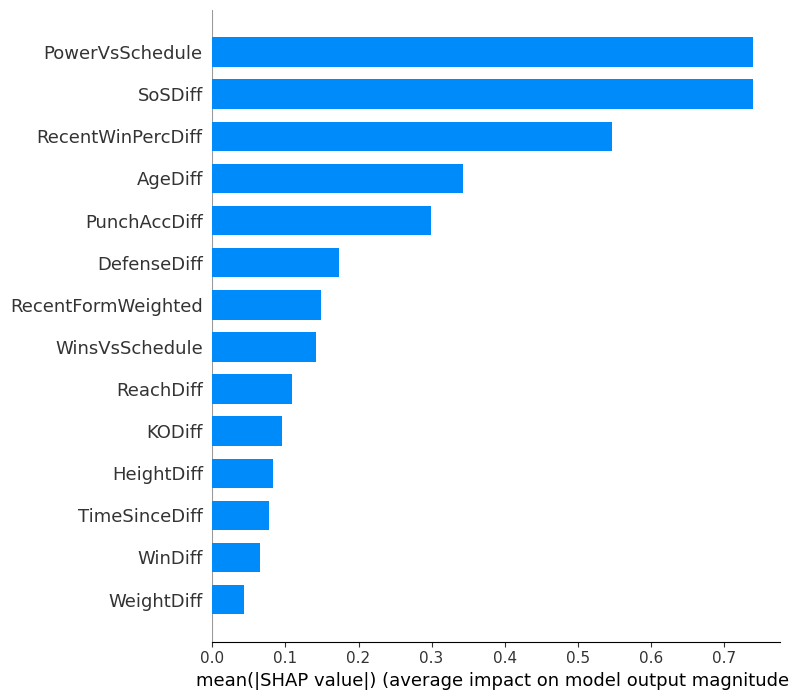

In [13]:
# Explainability with SHAP
# Finally, I wanted to understand why the model makes its predictions. I used the SHAP library to see how much each of my engineered features contributed to the final outcome for a specific fight. This made it easier for debugging and for trusting the models decisions.

# This cell calculates the overall importance of each feature across all predictions.
# It gives me a good idea of what my model considers most important in general.

if HAS_SHAP:
    # I'm using the XGBoost model from my ensemble for this global explanation.
    explainer = shap.Explainer(xgb_best, X_train_res)
    shap_values = explainer(X_test) # Explain predictions on the test set

    # I can then plot the mean SHAP value for each feature.
    print("Global Feature Importance (based on SHAP values):")
    shap.summary_plot(shap_values, X_test, plot_type="bar")
else:
    print("SHAP is not installed, so I can't show the feature importance plot.")